In [1]:
%config Completer.use_jedi = False
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def eval_regression(model, pred, xtrain, ytrain, xtest, ytest):
    print("MAE: %.2f" % mean_absolute_error(ytest, pred)) # The MAE
    print("RMSE: %.2f" % mean_squared_error(ytest, pred, squared=False)) 
    print('R2 score: %.2f' % r2_score(ytest, pred))
from scipy.stats import uniform
from sklearn.linear_model import Lasso, ElasticNet, Ridge, LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

In [2]:
wells = glob.glob('kalkulaksi/*')

In [3]:
np.random.seed(8812)
blind_test = []
for i in range(74):
    n = np.random.randint(0, len(wells))
    blind_test.append(wells[n])
    wells.pop(n)
model_dataset=wells

In [5]:
len(model_dataset),len(blind_test)

(200, 74)

In [7]:
dataset=pd.DataFrame([])

for well in model_dataset:
    asd=pd.read_csv(well).dropna(subset=["GR", "NPHI", "RHOB", "RT","Vshale","PHID","PHIT","PHIE","Sw"])
    dataset=pd.concat([dataset,asd])
    

In [8]:
dataset

,DEPT,DT,GR,NPHI,RHOB,RT,SP,GRMin,GRMax,PHISH,Rw,Vshale,PHID,PHIN,PHIT,PHIE,Sw
1706,853.0,80.9297,26.5268,0.272060,1.7312,100000.0000,4.3388,33997.000,53048.000,0.029,0.029,0.000000,0.592774,0.272060,0.461193,0.461193,0.001168
1707,853.5,78.5779,35.2117,0.278102,1.9110,100000.0000,7.5256,33997.000,53048.000,0.029,0.029,0.000000,0.476774,0.278102,0.390291,0.390291,0.001380
1708,854.0,78.1491,44.4713,0.330340,2.0323,100000.0000,11.2575,33997.000,53048.000,0.029,0.029,0.000000,0.398516,0.330340,0.366019,0.366019,0.001471
1709,854.5,80.3657,51.4354,0.358503,2.0497,100000.0000,15.2224,33997.000,53048.000,0.029,0.029,0.000000,0.387290,0.358503,0.373174,0.373174,0.001443
1710,855.0,84.5206,52.9506,0.376337,1.9479,100000.0000,19.1622,33997.000,53048.000,0.029,0.029,0.000000,0.452968,0.376337,0.416419,0.416419,0.001293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5755,3122.5,NaN,61.0962,9.413100,2.5257,172.0726,-44.5557,20.003,106.982,0.328,0.182,0.472450,0.080194,9.413100,1.000000,0.845037,0.038486
5756,3123.0,NaN,46.1199,7.859600,2.5690,157.2318,-47.7197,20.003,106.982,0.328,0.182,0.300267,0.052258,7.859600,1.000000,0.901513,0.037739
5757,3123.5,NaN,35.8030,7.072400,2.6053,142.6667,-50.6959,20.003,106.982,0.328,0.182,0.181653,0.028839,7.072400,1.000000,0.940418,0.037980
5758,3124.0,NaN,34.5347,6.657500,2.6299,127.3329,-53.6144,20.003,106.982,0.328,0.182,0.167071,0.012968,6.657500,1.000000,0.945201,0.039998


In [7]:
dataset.duplicated().sum()

0

In [8]:
x=dataset[['GR', 'NPHI', 'RHOB', 'RT']]
y=dataset[["Vshale","PHID","PHIT","PHIE","Sw"]]

,Vshale,PHID,PHIT,PHIE,Sw
1706,0.000000,0.592774,0.461193,0.461193,0.001168
1707,0.000000,0.476774,0.390291,0.390291,0.001380
1708,0.000000,0.398516,0.366019,0.366019,0.001471
1709,0.000000,0.387290,0.373174,0.373174,0.001443
1710,0.000000,0.452968,0.416419,0.416419,0.001293
...,...,...,...,...,...
5755,0.472450,0.080194,1.000000,0.845037,0.038486
5756,0.300267,0.052258,1.000000,0.901513,0.037739
5757,0.181653,0.028839,1.000000,0.940418,0.037980
5758,0.167071,0.012968,1.000000,0.945201,0.039998


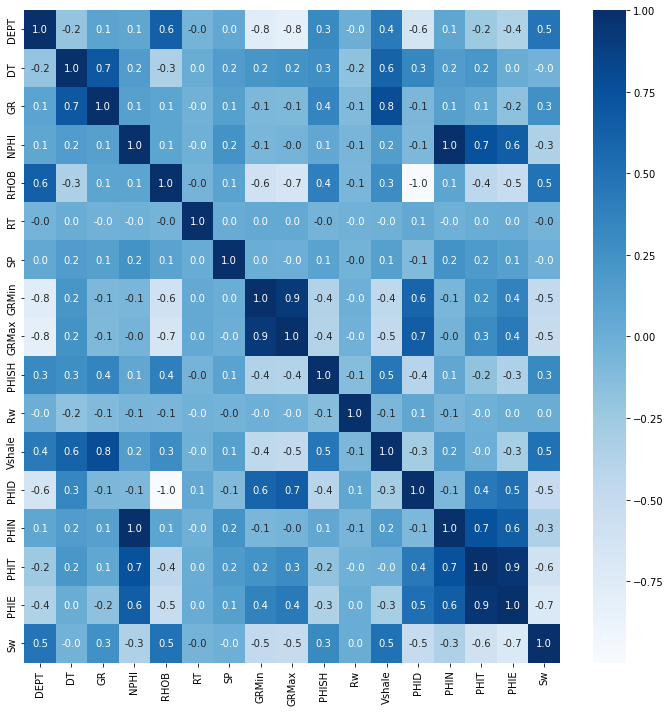

In [11]:
plt.figure(figsize=(12, 12))
sns.heatmap(dataset.corr(), cmap='Blues', annot=True, fmt='.1f');

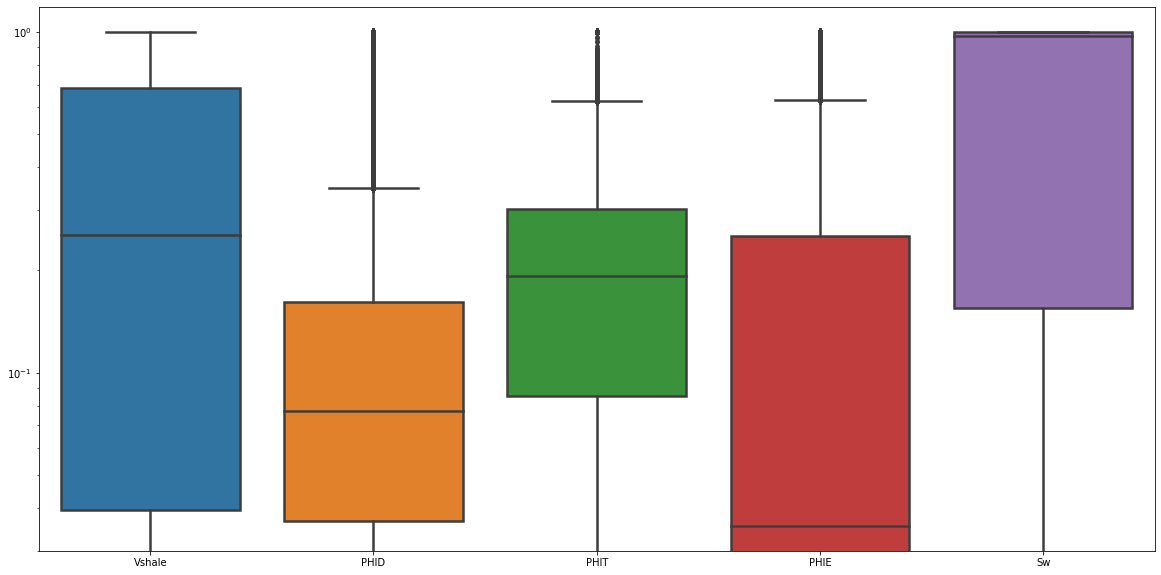

In [51]:
ukuran = (20, 10)
fig, ax = plt.subplots(figsize=ukuran)
g = sns.boxplot(data=y,linewidth=2.5,ax=ax)
g.set_yscale("log")

In [50]:
y["Vshale"]=MinMaxScaler().fit_transform(y["Vshale"].values.reshape(len(y),1))
y["PHID"]=MinMaxScaler().fit_transform(y["PHID"].values.reshape(len(y),1))
y["PHIT"]=MinMaxScaler().fit_transform(y["PHIT"].values.reshape(len(y),1))
y["PHIE"]=MinMaxScaler().fit_transform(y["PHIE"].values.reshape(len(y),1))
y["Sw"]=MinMaxScaler().fit_transform(y["Sw"].values.reshape(len(y),1))

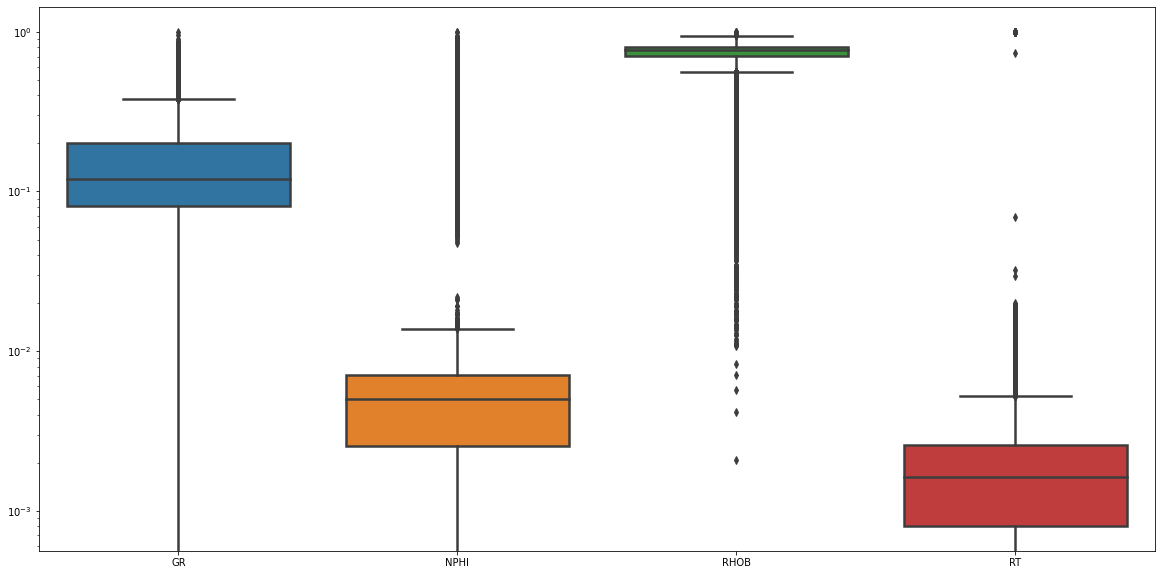

In [49]:
ukuran = (20, 10)
fig, ax = plt.subplots(figsize=ukuran)
g = sns.boxplot(data=x,linewidth=2.5,ax=ax)
g.set_yscale("log")

In [48]:
x["RHOB"]=MinMaxScaler().fit_transform(x["RHOB"].values.reshape(len(x),1))
x["GR"]=MinMaxScaler().fit_transform(x["GR"].values.reshape(len(x),1))
x["NPHI"]=MinMaxScaler().fit_transform(x["NPHI"].values.reshape(len(x),1))
x["RT"]=MinMaxScaler().fit_transform(x["RT"].values.reshape(len(x),1))

## SPLIT TRAIN TEST

In [54]:
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.2, random_state=42) #Splitting the data into Train and Test

## Linear Regression

In [55]:
LR=LinearRegression()
LR.fit(xtrain, ytrain)
pred=LR.predict(xtest)
eval_regression(LR,pred,xtrain,ytrain,xtest,ytest)
print("Train: %.4f" % LR.score(xtrain,ytrain),"Test: %.4f" % LR.score(xtest,ytest))


MAE: 0.11
RMSE: 0.15
R2 score: 0.74
Train: 0.7433 Test: 0.7441


## Ridge 

In [56]:
RM=Ridge()
RM.fit(xtrain,ytrain)
pred2=RM.predict(xtest)
eval_regression(RM,pred2,xtrain,ytrain,xtest,ytest)
print("Train: %.4f" % RM.score(xtrain,ytrain),"Test: %.4f" % RM.score(xtest,ytest))

MAE: 0.11
RMSE: 0.15
R2 score: 0.74
Train: 0.7433 Test: 0.7441


## Ridge Hyper 

In [57]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import uniform

alpha = [0.01, 0.1, 1, 2, 5, 10, 100, 200, 230, 250, 265, 270, 275, 290, 300, 500] # alpha
solver = ['lsqr', 'auto', 'sag', 'saga', 'cholesky']
fit_intercept = [True, False]
hyperparameters = dict(alpha=alpha, solver=solver, fit_intercept=fit_intercept)

from sklearn.linear_model import Ridge
ridge_model = Ridge()
clf = RandomizedSearchCV(ridge_model, hyperparameters, cv=5, random_state=42, scoring='r2')

#Fitting Model
best_model = clf.fit(xtrain, ytrain)
pred = best_model.predict(xtest)
eval_regression(best_model, pred, xtrain, ytrain, xtest, ytest)
best_model.score(xtrain,ytrain),best_model.score(xtest,ytest)

MAE: 0.11
RMSE: 0.15
R2 score: 0.74


(0.7432737435933957, 0.7441122891165184)

## Lasso

In [58]:
lasso_model = Lasso()
lasso_model.fit(xtrain, ytrain)
pred3=lasso_model.predict(xtest)
eval_regression(lasso_model,pred3,xtrain,ytrain,xtest,ytest)
lasso_model.score(xtrain,ytrain),lasso_model.score(xtest,ytest)

MAE: 0.26
RMSE: 0.32
R2 score: -0.00


(-1.0880185641326535e-15, -8.134100754437767e-05)

## Lasso Hyper

In [59]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

alpha = [0.02, 0.024, 0.025, 0.026, 0.03] # alpha or lambda
selection = ['cyclic', 'random']
hyperparameters = dict(alpha=alpha, selection=selection)

from sklearn.linear_model import Lasso
lasso_model = Lasso()
clf = RandomizedSearchCV(lasso_model, hyperparameters, cv=5, random_state=42, scoring='r2')

#Fitting Model
best_model2 = clf.fit(xtrain, ytrain)

pred = best_model2.predict(xtest)
eval_regression(best_model2, pred, xtrain, ytrain, xtest, ytest)
best_model2.score(xtrain,ytrain),best_model2.score(xtest,ytest)

MAE: 0.21
RMSE: 0.25
R2 score: 0.36


(0.3613904616081151, 0.3620276311931506)

## Random Forest

In [60]:
rf = RandomForestRegressor()
rf.fit(xtrain, ytrain)
pred4 = rf.predict(xtest)
eval_regression(rf, pred4, xtrain, ytrain, xtest, ytest)
rf.score(xtrain,ytrain),rf.score(xtest,ytest)

MAE: 0.03
RMSE: 0.06
R2 score: 0.95


(0.9932531983429957, 0.9533516811533407)

## ELastic Net

In [61]:
elasticnet_model = ElasticNet()
elasticnet_model.fit(xtrain, ytrain)
pred = elasticnet_model.predict(xtest)
eval_regression(elasticnet_model, pred, xtrain, ytrain, xtest, ytest)
elasticnet_model.score(xtrain,ytrain),elasticnet_model.score(xtest,ytest)

MAE: 0.26
RMSE: 0.32
R2 score: -0.00


(-1.0880185641326535e-15, -8.134100754437767e-05)

## Decision Tree

In [62]:
dt = DecisionTreeRegressor()
dt.fit(xtrain, ytrain)
pred = dt.predict(xtest)
eval_regression(dt, pred, xtrain, ytrain, xtest, ytest)
dt.score(xtrain,ytrain),dt.score(xtest,ytest)

MAE: 0.04
RMSE: 0.08
R2 score: 0.91


(1.0, 0.911422195953034)